In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
from shapely import wkt
import seaborn as sns
sns.set()
import requests
import json
import pymongo
import psycopg2

## ---------------------------------------------------------------------------------------
## Calling API to request the data
## ---------------------------------------------------------------------------------------

In [17]:
host_ip = '52.213.189.70'
MongoClient = pymongo.MongoClient(host_ip, 27017)

In [28]:
dbList = MongoClient.list_database_names()
print("Available Databases: ")
print(dbList)
print()

covid = MongoClient["Covid"]
covid_collections = covid.list_collection_names()
print("Available Collections")
print(covid_collections)

Available Databases: 
['Covid', 'Reddit', 'StockMarket', 'Twitter', 'admin', 'config', 'local']

Available Collections
['covidcollection']


In [25]:
covidcoll = covid["covidcollection"]

In [26]:
url = "https://api.covid19api.com/all?from=2020-04-20T00:00:00Z&to=2020-04-20T00:00:00Z"

payload = {}
headers= {}

response = requests.request("GET", url, headers=headers, data = payload)

data = response.json()

'with open(\'2nd/covid19.json\', \'w\', encoding=\'utf-8\') as f:\n    json.dump(data, f, ensure_ascii=False, indent=4)\n    \ndata2 = pd.read_json(\'2nd/covid19.json\')\ndata2.to_csv("2nd/covid19.csv", index=False)'

In [23]:
#covidcoll.delete_many({})
#covidcoll.drop()

In [20]:
#for i in covidcoll.find(): print(i)

In [27]:
# Data insertion to Mongodb

for eachdata in data:
    try:
        covidcoll.insert_one(eachdata)
    except:
        print("Error: ", eachdata)


In [34]:
corona_df = []
cursor = covidcoll.find({})
for document in cursor:
      corona_df.append(document)

corona_df = pd.DataFrame(corona_df)

In [41]:
corona_df.drop('_id', axis=1, inplace=True)

corona_df.head()

,Country,CountryCode,Province,City,CityCode,Lat,Lon,Confirmed,Deaths,Recovered,Active,Date
0,Afghanistan,AF,,,,33.94,67.71,0,0,0,0,2020-01-22T00:00:00Z
1,Afghanistan,AF,,,,33.94,67.71,0,0,0,0,2020-01-23T00:00:00Z
2,Afghanistan,AF,,,,33.94,67.71,0,0,0,0,2020-01-24T00:00:00Z
3,Afghanistan,AF,,,,33.94,67.71,0,0,0,0,2020-01-25T00:00:00Z
4,Afghanistan,AF,,,,33.94,67.71,0,0,0,0,2020-01-26T00:00:00Z


## ---------------------------------------------------------------------------------------
## Cleaning the Coronavirus dataframe
## ---------------------------------------------------------------------------------------

In [3]:
# Dropping columns that are not needed
corona_df.drop(['Province', 'City', 'CityCode', 'Lat', 'Lon', 'CountryCode'], axis=1, inplace=True)

# Converting the Date column from float to datetime data-type
corona_df['Date'] =  pd.to_datetime(corona_df['Date'])
corona_df.Date = corona_df.Date.dt.date
corona_df['Date'] =  pd.to_datetime(corona_df['Date'])
corona_df.head()

,Country,Confirmed,Deaths,Recovered,Active,Date
0,Afghanistan,0,0,0,0,2020-01-22
1,Afghanistan,0,0,0,0,2020-01-23
2,Afghanistan,0,0,0,0,2020-01-24
3,Afghanistan,0,0,0,0,2020-01-25
4,Afghanistan,0,0,0,0,2020-01-26


In [4]:
corona_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319683 entries, 0 to 319682
Data columns (total 6 columns):
Country      319683 non-null object
Confirmed    319683 non-null int64
Deaths       319683 non-null int64
Recovered    319683 non-null int64
Active       319683 non-null int64
Date         319683 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 14.6+ MB


In [5]:
# Some countries, such as China, are split into different provinces/states. 
# Since we just want the total number of cases per country, we get the sum for each country at each date:
sum_df = corona_df.groupby(['Country', 'Date'], as_index=False).sum()

In [6]:
sum_df.head()

,Country,Date,Confirmed,Deaths,Recovered,Active
0,Afghanistan,2020-01-22,0,0,0,0
1,Afghanistan,2020-01-23,0,0,0,0
2,Afghanistan,2020-01-24,0,0,0,0
3,Afghanistan,2020-01-25,0,0,0,0
4,Afghanistan,2020-01-26,0,0,0,0


In [7]:
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16653 entries, 0 to 16652
Data columns (total 6 columns):
Country      16653 non-null object
Date         16653 non-null datetime64[ns]
Confirmed    16653 non-null int64
Deaths       16653 non-null int64
Recovered    16653 non-null int64
Active       16653 non-null int64
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 910.7+ KB


## ---------------------------------------------------------------------------------------
## Extracting the Dates
## ---------------------------------------------------------------------------------------

In [9]:
# Extracting the date column from the dataframe
# This will come in handy later when merging dataframes on the date column, and when looping over the date to plot the map

date_list = pd.DataFrame(sum_df.Date.unique())
date_list.rename(columns = {0:'Date'}, inplace = True)
date_list = date_list.loc[date_list.Date <= '2020-04-13']
date_list.reset_index(drop=True, inplace=True)
date_list.to_csv('date_list.csv', encoding='utf-8', index=False)

## ---------------------------------------------------------------------------------------
## Reading and cleaning the shape file
## ---------------------------------------------------------------------------------------

In [12]:
# Shape file for plotting world maps
shape_file = gpd.read_file('shape_files/Countries_WGS84.shp')

In [13]:
shape_file.head()

,OBJECTID,CNTRY_NAME,geometry
0,1,Aruba,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,2,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,3,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,4,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,5,Azerbaijan,"MULTIPOLYGON (((45.02583 41.03055, 45.00999 41..."


In [14]:
# Dropping columns that are not needed
shape_file.drop('OBJECTID', axis=1, inplace=True)

# Renaming columns
shape_file.rename(columns = {'CNTRY_NAME':'Country'},
               inplace = True)

In [15]:
shape_file.head()

,Country,geometry
0,Aruba,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,Azerbaijan,"MULTIPOLYGON (((45.02583 41.03055, 45.00999 41..."


In [16]:
shape_file.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
Country     251 non-null object
geometry    251 non-null geometry
dtypes: geometry(1), object(1)
memory usage: 4.0+ KB


## ---------------------------------------------------------------------------------------
## Comparing and renaming the country names in Coronavirus dataframe
## ---------------------------------------------------------------------------------------

In [17]:
# Making the country names match between the dataframe and the shapefile


sum_df = sum_df.replace({'Country' : 'Bahamas'}, 'Bahamas, The')
sum_df = sum_df.replace({'Country' : 'Belarus'}, 'Byelarus')
sum_df = sum_df.replace({'Country' : 'Brunei Darussalam'}, 'Brunei')
sum_df = sum_df.replace({'Country' : 'Congo (Kinshasa)'}, 'Congo')
sum_df = sum_df.replace({'Country' : 'Gambia'}, 'Gambia, The')
sum_df = sum_df.replace({'Country' : 'Iran, Islamic Republic of'}, 'Iran')
sum_df = sum_df.replace({'Country' : 'Korea (South)'}, 'South Korea')
sum_df = sum_df.replace({'Country' : 'Lao PDR'}, 'Laos')
sum_df = sum_df.replace({'Country' : 'Macedonia, Republic of'}, 'Macedonia')
sum_df = sum_df.replace({'Country' : 'Myanmar'}, 'Myanmar (Burma)')
sum_df = sum_df.replace({'Country' : 'Russian Federation'}, 'Russia')
sum_df = sum_df.replace({'Country' : 'Saint Kitts and Nevis'}, 'St. Kitts and Nevis')
sum_df = sum_df.replace({'Country' : 'Saint Lucia'}, 'St. Lucia')
sum_df = sum_df.replace({'Country' : 'Saint Vincent and Grenadines'}, 'St. Vincent and Grenadines')
sum_df = sum_df.replace({'Country' : 'Syrian Arab Republic (Syria)'}, 'Syria')
sum_df = sum_df.replace({'Country' : 'Taiwan, Republic of China'}, 'Taiwan')
sum_df = sum_df.replace({'Country' : 'United States of America'}, 'United States')
sum_df = sum_df.replace({'Country' : 'Venexuela (Bolivarian Republic)'}, 'Venezuela')
sum_df = sum_df.replace({'Country' : 'Viet Nam'}, 'Vietnam')

## ---------------------------------------------------------------------------------------
## Extracting the country names
## ---------------------------------------------------------------------------------------

In [18]:
# Extracting the country column from the dataframe
# This will come in handy later when merging dataframes on the country column

country_list = pd.DataFrame(shape_file.Country.unique())
country_list.rename(columns = {0:'Country'}, inplace = True) 
country_list.to_csv('country_list.csv', encoding='utf-8', index=False)

## ---------------------------------------------------------------------------------------------
## Merging the Dates and Countries to form one single dataframe with all Countries and all Dates
## ---------------------------------------------------------------------------------------------

In [19]:
# Merging the date and country dataframes such that the date from January to April is available for EACH country

def cartesian_product_simplified(left, right):
    la, lb = len(left), len(right)
    ia2, ib2 = np.broadcast_arrays(*np.ogrid[:la,:lb])

    return pd.DataFrame(
        np.column_stack([left.values[ia2.ravel()], right.values[ib2.ravel()]]))

country_date_list = cartesian_product_simplified(country_list, date_list)

In [20]:
country_date_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20833 entries, 0 to 20832
Data columns (total 2 columns):
0    20833 non-null object
1    20833 non-null object
dtypes: object(2)
memory usage: 325.6+ KB


In [21]:
# Renaming Columns
country_date_list.rename(columns = {0:'Country', 1:'Date'},
                          inplace = True)  

In [22]:
country_date_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20833 entries, 0 to 20832
Data columns (total 2 columns):
Country    20833 non-null object
Date       20833 non-null object
dtypes: object(2)
memory usage: 325.6+ KB


In [23]:
# Coverting from float to datetime
country_date_list['Date'] = pd.to_datetime(country_date_list['Date'])

In [24]:
country_date_list.head()

,Country,Date
0,Aruba,2020-01-22
1,Aruba,2020-01-23
2,Aruba,2020-01-24
3,Aruba,2020-01-25
4,Aruba,2020-01-26


In [25]:
country_date_list.to_csv('country_date_list.csv', encoding='utf-8', index=False)

## ---------------------------------------------------------------------------------------
## Merging the Coronavirus dataframe and the country-date-dataframe
## ---------------------------------------------------------------------------------------

In [26]:
# Merging the sum_dataframe and the country-date-dataframe, such that:
#     1. Only countries that are common in both dataframes are merged
#     2. The countries that are present in the country-date-dataframe 
#        but not in the sum_dataframe are NOT removed - otherwise map for that country will be blank

# Also, this way, the countries that didn't have COVID-19 data will still be given dates -- so there will be no null values in the date column, 
# which is important because the date is the factor that will be looped over
# All the null values in countries that didn't have any COVID-19 data can be filled in later

merged = pd.merge(country_date_list, sum_df, how='left', left_on=['Country', 'Date'], right_on=['Country', 'Date'])

In [27]:
merged.head()

,Country,Date,Confirmed,Deaths,Recovered,Active
0,Aruba,2020-01-22,NaN,NaN,NaN,NaN
1,Aruba,2020-01-23,NaN,NaN,NaN,NaN
2,Aruba,2020-01-24,NaN,NaN,NaN,NaN
3,Aruba,2020-01-25,NaN,NaN,NaN,NaN
4,Aruba,2020-01-26,NaN,NaN,NaN,NaN


In [28]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20833 entries, 0 to 20832
Data columns (total 6 columns):
Country      20833 non-null object
Date         20833 non-null datetime64[ns]
Confirmed    14442 non-null float64
Deaths       14442 non-null float64
Recovered    14442 non-null float64
Active       14442 non-null float64
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1.1+ MB


## ---------------------------------------------------------------------------------------
## Filling null values in the merged dataframe
## ---------------------------------------------------------------------------------------

In [29]:
# Checking the percentage of null values

def printNullValues(df):
    total = df.isnull().sum().sort_values(ascending = False)
    total = total[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = total * 100 / len(df)
    percent = percent[df.isnull().sum().sort_values(ascending = False) != 0]
    concat = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    print (concat)
    print ( "-------------")
    
printNullValues(merged)

           Total    Percent
Active      6391  30.677291
Recovered   6391  30.677291
Deaths      6391  30.677291
Confirmed   6391  30.677291
-------------


In [30]:
# Filling null values with zero

merged['Confirmed'] = merged['Confirmed'].fillna(0)
merged['Deaths'] = merged['Deaths'].fillna(0)
merged['Recovered'] = merged['Recovered'].fillna(0)
merged['Active'] = merged['Active'].fillna(0)

# Null date columns mean that data for that country is not present
# Replacing those null values with a dummy date
end = pd.to_datetime('2020-4-20')
merged['Date'] = merged['Date'].fillna(end)


In [31]:
# Checking the percentage of null values again

def printNullValues(df):
    total = df.isnull().sum().sort_values(ascending = False)
    total = total[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = total * 100 / len(df)
    percent = percent[df.isnull().sum().sort_values(ascending = False) != 0]
    concat = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    print (concat)
    print ( "-------------")
    
printNullValues(merged)

Empty DataFrame
Columns: [Total, Percent]
Index: []
-------------


In [32]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20833 entries, 0 to 20832
Data columns (total 6 columns):
Country      20833 non-null object
Date         20833 non-null datetime64[ns]
Confirmed    20833 non-null float64
Deaths       20833 non-null float64
Recovered    20833 non-null float64
Active       20833 non-null float64
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1.1+ MB


## ---------------------------------------------------------------------------------------
## Merging the merged Coronavirus dataframe and the shape file
## ---------------------------------------------------------------------------------------

In [33]:
# Finally merging the shape-file and the merged-dataframe
# Now all countries will have a date, and a geometry column to plot the country shape on the world map

final = pd.merge(merged, shape_file, on='Country')

In [34]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20833 entries, 0 to 20832
Data columns (total 7 columns):
Country      20833 non-null object
Date         20833 non-null datetime64[ns]
Confirmed    20833 non-null float64
Deaths       20833 non-null float64
Recovered    20833 non-null float64
Active       20833 non-null float64
geometry     20833 non-null geometry
dtypes: datetime64[ns](1), float64(4), geometry(1), object(1)
memory usage: 1.3+ MB


In [35]:
final.head()

,Country,Date,Confirmed,Deaths,Recovered,Active,geometry
0,Aruba,2020-01-22,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,Aruba,2020-01-23,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
2,Aruba,2020-01-24,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
3,Aruba,2020-01-25,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
4,Aruba,2020-01-26,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."


In [48]:
# Checking the percentage of null values again

def printNullValues(df):
    total = df.isnull().sum().sort_values(ascending = False)
    total = total[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = total * 100 / len(df)
    percent = percent[df.isnull().sum().sort_values(ascending = False) != 0]
    concat = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    print (concat)
    print ( "-------------")
    
printNullValues(final)

Empty DataFrame
Columns: [Total, Percent]
Index: []
-------------


## ---------------------------------------------------------------------------------------
## Creating log10 columns for values
## ---------------------------------------------------------------------------------------

In [36]:
# Making new columns for log10(Confirmed Cases) and log10(Deaths)

final['log_Confirmed'] = np.log10(final['Confirmed'])
final['log_Deaths'] = np.log10(final['Deaths'])

# Since log10(0) = - inf, and many values are 0
# Replacing all values smaller than 0 with 0

final.log_Confirmed[final.log_Confirmed < 0] = 0
final.log_Deaths[final.log_Deaths < 0] = 0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [37]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20833 entries, 0 to 20832
Data columns (total 9 columns):
Country          20833 non-null object
Date             20833 non-null datetime64[ns]
Confirmed        20833 non-null float64
Deaths           20833 non-null float64
Recovered        20833 non-null float64
Active           20833 non-null float64
geometry         20833 non-null geometry
log_Confirmed    20833 non-null float64
log_Deaths       20833 non-null float64
dtypes: datetime64[ns](1), float64(6), geometry(1), object(1)
memory usage: 1.6+ MB


In [38]:
final.tail()

,Country,Date,Confirmed,Deaths,Recovered,Active,geometry,log_Confirmed,log_Deaths
20828,Zimbabwe,2020-04-09,11.0,3.0,0.0,0.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",1.041393,0.477121
20829,Zimbabwe,2020-04-10,13.0,3.0,0.0,0.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",1.113943,0.477121
20830,Zimbabwe,2020-04-11,14.0,3.0,0.0,0.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",1.146128,0.477121
20831,Zimbabwe,2020-04-12,14.0,3.0,0.0,0.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",1.146128,0.477121
20832,Zimbabwe,2020-04-13,17.0,3.0,0.0,0.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",1.230449,0.477121


## ---------------------------------------------------------------------------------------
## Removing Antarctica
## ---------------------------------------------------------------------------------------

In [41]:
# Antarctica is not inhabited
# So removing it from the countries to map

antarctica_loc = final.loc[final.Country == 'Antarctica']
antarctica_loc.index.unique()

Int64Index([1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172,
            1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183,
            1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194,
            1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205,
            1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216,
            1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227,
            1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238,
            1239, 1240, 1241, 1242, 1243, 1244],
           dtype='int64')

In [42]:
# Dropping the rows that represnt Antarctica

final.drop(final.index[[1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172,
            1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183,
            1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194,
            1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205,
            1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216,
            1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227,
            1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238,
            1239, 1240, 1241, 1242, 1243, 1244]], inplace=True)

In [43]:
# Confirming by looking up the dataframe

final.loc[final.Country == 'Antarctica']

,Country,Date,Confirmed,Deaths,Recovered,Active,geometry,log_Confirmed,log_Deaths


In [44]:
# Resetting the index

final.reset_index(drop=True, inplace=True)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20750 entries, 0 to 20749
Data columns (total 9 columns):
Country          20750 non-null object
Date             20750 non-null datetime64[ns]
Confirmed        20750 non-null float64
Deaths           20750 non-null float64
Recovered        20750 non-null float64
Active           20750 non-null float64
geometry         20750 non-null geometry
log_Confirmed    20750 non-null float64
log_Deaths       20750 non-null float64
dtypes: datetime64[ns](1), float64(6), geometry(1), object(1)
memory usage: 1.4+ MB


In [45]:
final.head()

,Country,Date,Confirmed,Deaths,Recovered,Active,geometry,log_Confirmed,log_Deaths
0,Aruba,2020-01-22,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436...",0.0,0.0
1,Aruba,2020-01-23,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436...",0.0,0.0
2,Aruba,2020-01-24,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436...",0.0,0.0
3,Aruba,2020-01-25,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436...",0.0,0.0
4,Aruba,2020-01-26,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436...",0.0,0.0


In [46]:
final.tail()

,Country,Date,Confirmed,Deaths,Recovered,Active,geometry,log_Confirmed,log_Deaths
20745,Zimbabwe,2020-04-09,11.0,3.0,0.0,0.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",1.041393,0.477121
20746,Zimbabwe,2020-04-10,13.0,3.0,0.0,0.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",1.113943,0.477121
20747,Zimbabwe,2020-04-11,14.0,3.0,0.0,0.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",1.146128,0.477121
20748,Zimbabwe,2020-04-12,14.0,3.0,0.0,0.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",1.146128,0.477121
20749,Zimbabwe,2020-04-13,17.0,3.0,0.0,0.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",1.230449,0.477121


In [47]:
# Saving the dataframe to csv

edited_master = final
edited_master = edited_master.astype(object)
edited_master.to_csv('edited_master.csv', encoding='utf-8', index=False)

## ---------------------------------------------------------------------------------------
## Final data type changes
## ---------------------------------------------------------------------------------------

In [62]:
# The geometry column is needed to plot the world map
# But the data type should be geopandas.geometry type and not float
# Converting the data-type to geometry

# final['geometry'] = final['geometry'].apply(wkt.loads)


# Converting from pandas dataframe to geopandas dataframe
geometry = final.geometry
crs = {'init': 'epsg:4326'}
final = gpd.GeoDataFrame(final, crs=crs, geometry=geometry)
final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20750 entries, 0 to 20749
Data columns (total 9 columns):
Country          20750 non-null object
Date             20750 non-null datetime64[ns]
Confirmed        20750 non-null float64
Deaths           20750 non-null float64
Recovered        20750 non-null float64
Active           20750 non-null float64
geometry         20750 non-null geometry
log_Confirmed    20750 non-null float64
log_Deaths       20750 non-null float64
dtypes: datetime64[ns](1), float64(6), geometry(1), object(1)
memory usage: 1.4+ MB


## ---------------------------------------------------------------------------------------
## Selecting test-dates for test-plotting
## ---------------------------------------------------------------------------------------

In [53]:
# Selecting specific dates from the date list

print(date_list.loc[date_list.Date == '2020-01-22'])
print(date_list.loc[date_list.Date == '2020-02-20'])
print(date_list.loc[date_list.Date == '2020-03-20'])
print(date_list.loc[date_list.Date == '2020-04-13'])

        Date
0 2020-01-22
         Date
29 2020-02-20
         Date
58 2020-03-20
         Date
82 2020-04-13


In [54]:
date_list_test = date_list.iloc[[0, 29, 58, 82]]

In [55]:
date_list_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 82
Data columns (total 1 columns):
Date    4 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 64.0 bytes


In [56]:
date_list_test.reset_index(drop=True, inplace=True)
date_list_test.head()

,Date
0,2020-01-22
1,2020-02-20
2,2020-03-20
3,2020-04-13


## ---------------------------------------------------------------------------------------
## Plotting the multiple maps for test-dates
## ---------------------------------------------------------------------------------------

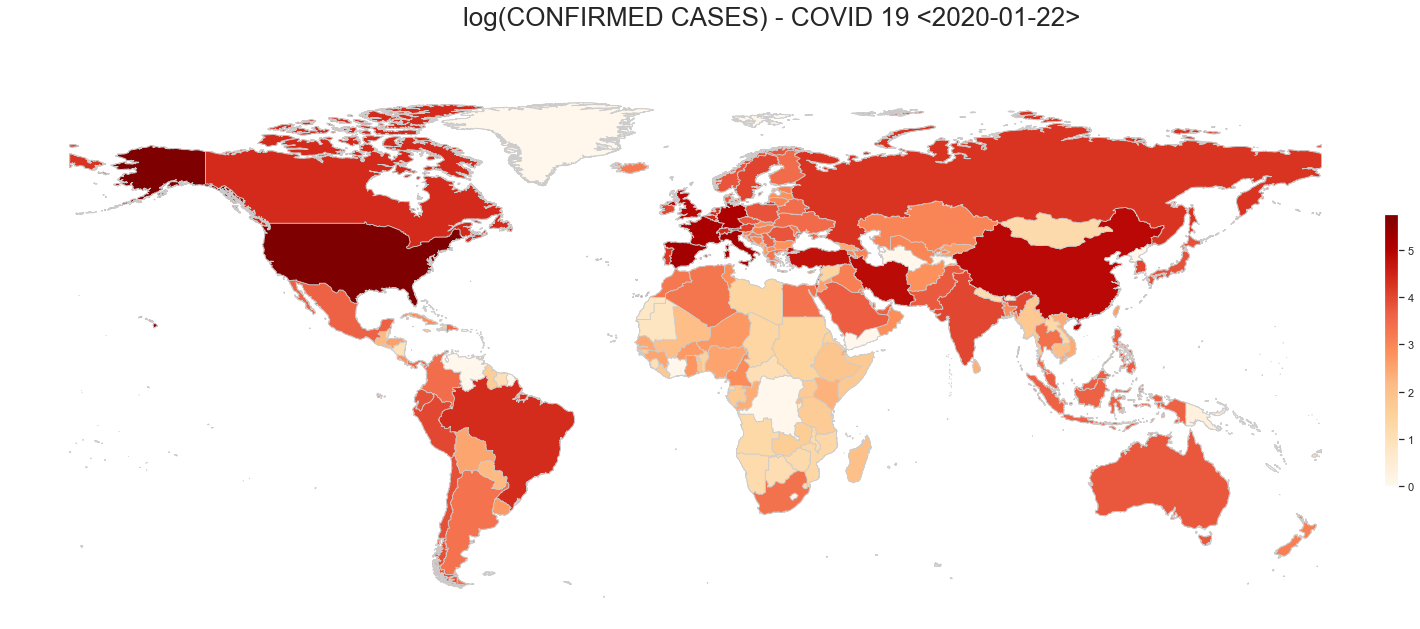

In [79]:
image_no = 0
vmin, vmax = 0, final.log_Confirmed[final.Date == '2020-04-13'].max()
fig, ax = plt.subplots(1, figsize=(30, 10))
variable = 'log_Confirmed'
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
fig.colorbar(sm, pad = 0.0001, shrink=0.5)


for i in range(0, len(date_list_test)):   
    date_for_mask = date_list_test.Date.values[i]
    mask = (final['Date'] == date_for_mask)
    my_map = final.loc[mask]
    ax.axis('off')
    fig.suptitle('log(CONFIRMED CASES) - COVID 19 <' + str(date_list_test.Date.dt.date.values[0]) + '>', fontsize=26, fontweight = 3)
    my_map.plot(column=variable, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
    fig.savefig('WORLD_MAP_{image_no:04d}.png'.format(image_no=image_no), 
                dpi=300, bbox_inches='tight')
    image_no +=1